In [1]:
#! /usr/bin/env python
"""
Histograms of the calibrated parameters for each region
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib


import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat, create_glacfeat
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func
from spc_split_lists import split_list


debug=False

In [2]:
rois = ['01','02','03','04','05','06','07','08','09','10','11','12','HMA','16','17','18']
# rois = ['02']

In [3]:
# ===== DETERMINE ALL GLACIERS WITH AND WITHOUT OBSERVATIONS =====
main_glac_rgi_rois_tsopt = None
for roi in rois:
    hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi + '/'

    # Glaciers optimized
    glac_tsopt_fns = []
    rgiid_list_tsopt = []
    hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi + '/'
    for i in os.listdir(hdopt_prms_fp):
        if i.endswith('_hdopt_prms.csv'):
            region = int(i.split('.')[0])
            if region in debris_prms.roi_rgidict[roi]:    
                rgiid_list_tsopt.append(i.split('_')[0])            
                glac_tsopt_fns.append(i)
    glac_tsopt_fns = sorted(glac_tsopt_fns)
    glac_tsopt_fullfns = [hdopt_prms_fp + x for x in glac_tsopt_fns]
    rgiid_list_tsopt = sorted(rgiid_list_tsopt)

    main_glac_rgi_tsopt = debris_prms.selectglaciersrgitable(rgiid_list_tsopt)
    
    hdopt_cns = ['glac_str', 'melt_mwea_clean', 'melt_mwea_2cm', 'b0', 'k', 'a', 'b', 'c']
    for cn in hdopt_cns:
        main_glac_rgi_tsopt[cn] = np.nan
    
    # Add model parameters
    for nglac, glac_tsopt_fullfn in enumerate(glac_tsopt_fullfns):
        hdopt_df = pd.read_csv(glac_tsopt_fullfn)
        main_glac_rgi_tsopt.loc[nglac,hdopt_cns] = hdopt_df.loc[0,hdopt_cns].values
        
#     main_glac_rgi_tsopt['hdopt_fn'] = [hdopt_prms_fp + x for x in glac_tsopt_fns]
    
    if main_glac_rgi_rois_tsopt is None:
        main_glac_rgi_rois_tsopt = main_glac_rgi_tsopt.copy()
    else:
        main_glac_rgi_rois_tsopt = pd.concat([main_glac_rgi_rois_tsopt, main_glac_rgi_tsopt], 
                                             axis=0, ignore_index=True)

# Add roi  
main_glac_rgi_rois_tsopt['roi'] = [str(x).zfill(2) for x in main_glac_rgi_rois_tsopt['O1Region'].values]
main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == '13', 'roi'] = 'HMA'
main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == '14', 'roi'] = 'HMA'
main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == '15', 'roi'] = 'HMA'
main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == 'HMA']
        
print('\nall regions: calibration includes', main_glac_rgi_rois_tsopt.shape[0], 'glaciers')   

739 glaciers in region 1 are included in this model run: ['00013', '00033', '00038', '00040', '00041', '00042', '00044', '00045', '00046', '00140', '00148', '00312', '00351', '00399', '00409', '00426', '00434', '00436', '00537', '00544', '00556', '00557', '00561', '00566', '00569', '00570', '00571', '00572', '00574', '00576', '00578', '00579', '00581', '00582', '00584', '00600', '00660', '00675', '00732', '00739', '00746', '00814', '00852', '00870', '00871', '00903', '00942', '00951', '00962', '01150'] and more
This study is focusing on 739 glaciers in region [1]
136 glaciers in region 2 are included in this model run: ['00737', '00914', '01104', '01152', '01158', '01161', '01290', '01291', '01297', '01339', '01397', '01441', '01665', '01685', '01727', '01811', '01812', '01922', '01923', '02107', '02348', '02360', '02386', '02432', '02526', '02533', '02550', '02551', '02616', '02686', '02745', '02747', '02752', '02784', '02857', '02894', '02897', '02947', '02948', '02966', '03099', '03

In [4]:
main_glac_rgi_rois_tsopt.columns

Index(['O1Index', 'RGIId', 'CenLon', 'CenLat', 'O1Region', 'O2Region', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Form', 'TermType',
       'Surging', 'RefDate', 'glacno', 'rgino_str', 'RGIId_float', 'glac_str',
       'melt_mwea_clean', 'melt_mwea_2cm', 'b0', 'k', 'a', 'b', 'c', 'roi'],
      dtype='object')

b0 (med/min/max): 19.120920599658767 3.218725838395581 88.34365775582151
k (med/min/max): 1.4530102877872602 0.7357502883168252 11.17704830638259


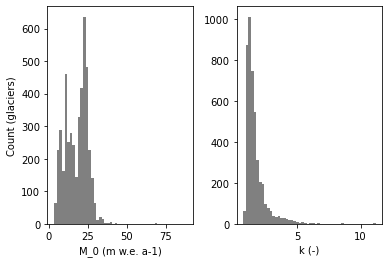

In [23]:
# HISTOGRAMS OF SPREAD
fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw = {'wspace':0.3, 'hspace':0.3})

labelsize = 12

# fig.text(0.5,0.9, 'All calibrated glaciers', ha='center', size=14)

ax[0].hist(main_glac_rgi_rois_tsopt['b0'], bins=50, color='grey')
ax[0].set_xlabel('M_0 (m w.e. a-1)')
ax[0].set_ylabel('Count (glaciers)')

ax[1].hist(main_glac_rgi_rois_tsopt['k'], bins=50, color='grey')
ax[1].set_xlabel('k (-)')

print('b0 (med/min/max):', 
          np.median(main_glac_rgi_rois_tsopt['b0']), 
          np.min(main_glac_rgi_rois_tsopt['b0']), 
          np.max(main_glac_rgi_rois_tsopt['b0']))
print('k (med/min/max):', 
          np.median(main_glac_rgi_rois_tsopt['k']), 
          np.min(main_glac_rgi_rois_tsopt['k']), 
          np.max(main_glac_rgi_rois_tsopt['k']))

fig.savefig(debris_prms.output_fp + 'hdopt_hist-all.png',  
            pad_inches=0, dpi=150)

01 b0 (med/min/max/95%): 11.39 9.12 22.6 14.73
02 b0 (med/min/max/95%): 14.54 12.41 16.57 15.89
03 b0 (med/min/max/95%): 5.45 3.8 6.73 6.31
04 b0 (med/min/max/95%): 7.91 5.85 9.15 8.4
05 b0 (med/min/max/95%): 8.81 3.39 13.58 10.68
06 b0 (med/min/max/95%): 14.04 10.28 19.91 19.4
07 b0 (med/min/max/95%): 5.78 4.88 8.16 7.63
08 b0 (med/min/max/95%): 10.81 9.65 11.97 11.85
09 b0 (med/min/max/95%): 6.29 3.22 6.84 6.83
10 b0 (med/min/max/95%): 15.62 15.29 18.32 17.67
11 b0 (med/min/max/95%): 15.09 13.71 17.88 16.25
12 b0 (med/min/max/95%): 16.13 14.95 17.24 16.7
HMA b0 (med/min/max/95%): 22.94 15.92 88.34 28.59
16 b0 (med/min/max/95%): 20.01 19.69 21.71 20.65
17 b0 (med/min/max/95%): 17.69 12.99 39.57 32.86
18 b0 (med/min/max/95%): 19.65 16.63 22.13 21.29


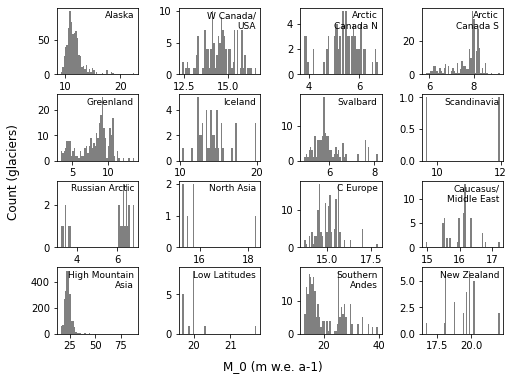

In [21]:
fig, ax = plt.subplots(4,4, figsize=(8,6), gridspec_kw = {'wspace':0.5, 'hspace':0.3})
roi_dict_name = {'01':'Alaska',
                 '02':'W Canada/\nUSA',
                 '03':'Arctic\nCanada N',
                 '04':'Arctic\nCanada S',
                 '05':'Greenland',
                 '06':'Iceland',
                 '07':'Svalbard',
                 '08':'Scandinavia',
                 '09':'Russian Arctic',
                 '10':'North Asia',
                 '11':'C Europe',
                 '12':'Caucasus/\nMiddle East',
                 'HMA':'High Mountain\nAsia',
                 '16':'Low Latitudes',
                 '17':'Southern\nAndes',
                 '18':'New Zealand'}

nrow = 0
ncol = 0
for nroi, roi in enumerate(rois):
    main_glac_rgi_subset = main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == roi]
    ax[nrow,ncol].hist(main_glac_rgi_subset['b0'], bins=50, color='grey')
    ax[nrow,ncol].text(0.95,0.95, roi_dict_name[roi], ha='right', va='top', 
                       transform=ax[nrow, ncol].transAxes, size=9)
    print(roi + ' b0 (med/min/max/95%):', 
          np.round(np.median(main_glac_rgi_subset['b0']),2), 
          np.round(np.min(main_glac_rgi_subset['b0']),2), 
          np.round(np.max(main_glac_rgi_subset['b0']),2),
          np.round(np.percentile(main_glac_rgi_subset['b0'],95),2))
    
    ncol = ncol + 1
    if ncol%4 == 0:
        nrow = nrow+1
        ncol = 0
    
fig.text(0.05,0.5, 'Count (glaciers)', ha='center', va='center', rotation='vertical', size=12)
fig.text(0.5,0.05, 'M_0 (m w.e. a-1)', ha='center', va='center', size=12)
fig.savefig(debris_prms.output_fp + 'hdopt_hist_b0-all.png', bbox_inches='tight',
            pad_inches=0, dpi=150)

01 k (med/min/max/95%): 1.65 1.17 2.38 2.15
02 k (med/min/max/95%): 1.56 1.19 2.16 1.86
03 k (med/min/max/95%): 4.0 2.6 6.73 5.48
04 k (med/min/max/95%): 2.48 2.06 6.76 4.34
05 k (med/min/max/95%): 2.15 1.45 6.07 4.62
06 k (med/min/max/95%): 2.26 1.65 3.09 3.07
07 k (med/min/max/95%): 3.3 2.55 5.58 4.58
08 k (med/min/max/95%): 2.12 1.8 2.44 2.41
09 k (med/min/max/95%): 3.93 3.32 11.18 11.01
10 k (med/min/max/95%): 1.89 1.66 2.24 2.19
11 k (med/min/max/95%): 1.38 1.15 1.66 1.54
12 k (med/min/max/95%): 1.26 1.13 1.55 1.36
HMA k (med/min/max/95%): 1.22 0.84 2.66 1.74
16 k (med/min/max/95%): 0.75 0.74 1.06 1.04
17 k (med/min/max/95%): 1.89 1.02 3.05 2.83
18 k (med/min/max/95%): 1.12 1.01 1.36 1.23


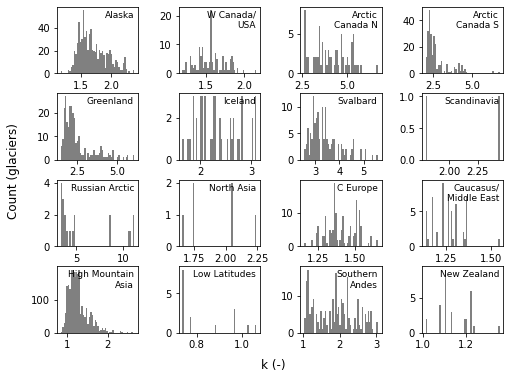

In [20]:
fig, ax = plt.subplots(4,4, figsize=(8,6), gridspec_kw = {'wspace':0.5, 'hspace':0.3})

nrow = 0
ncol = 0
for nroi, roi in enumerate(rois):
    main_glac_rgi_subset = main_glac_rgi_rois_tsopt.loc[main_glac_rgi_rois_tsopt['roi'] == roi]
    ax[nrow,ncol].hist(main_glac_rgi_subset['k'], bins=50, color='grey')
    ax[nrow,ncol].text(0.95,0.95, roi_dict_name[roi], ha='right', va='top', 
                       transform=ax[nrow, ncol].transAxes, size=9)
    print(roi + ' k (med/min/max/95%):', 
          np.round(np.median(main_glac_rgi_subset['k']),2), 
          np.round(np.min(main_glac_rgi_subset['k']),2), 
          np.round(np.max(main_glac_rgi_subset['k']),2),
          np.round(np.percentile(main_glac_rgi_subset['k'],95),2))
    
    ncol = ncol + 1
    if ncol%4 == 0:
        nrow = nrow+1
        ncol = 0
    
fig.text(0.05,0.5, 'Count (glaciers)', ha='center', va='center', rotation='vertical', size=12)
fig.text(0.5,0.05, 'k (-)', ha='center', va='center', size=12)
fig.savefig(debris_prms.output_fp + 'hdopt_hist_k-all.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)